## Notebook Vae kaggle

In [ ]:
!pip install -r ../requirements.txt

In [1]:
from torch import nn, optim
import torch

import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import models
import torchvision.transforms as transforms
from facenet_pytorch import InceptionResnetV1
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from PIL import Image
import matplotlib.pyplot as plt
import os

from pytorch_metric_learning.miners import BatchHardMiner
from pytorch_metric_learning.losses import TripletMarginLoss

import lpips
import time
import kagglehub

/home/e20210000275/M2/Projet Image/Face-Swap-M2/venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import utils
import dataloader

In [36]:

from sklearn.datasets import fetch_olivetti_faces
data = fetch_olivetti_faces(shuffle=True, random_state=42)
images = data.images  # Images de taille (64, 64)

downloading Olivetti faces from https://ndownloader.figshare.com/files/5976027 to /home/e20210000275/scikit_learn_data


In [34]:
print("Cuda compatible : ", torch.cuda.is_available())
device = "cuda" if torch.cuda.is_available() else "cpu"

Cuda compatible :  True


In [68]:

from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import Compose, Resize, ToTensor, Normalize

# Charger le dataset Olivetti Faces
from sklearn.datasets import fetch_olivetti_faces
data = fetch_olivetti_faces(shuffle=True, random_state=42)
images = data.images  # Images de taille (64, 64)
labels = data.target  # Les labels associés aux images

# Définir les transformations pour les images
transform = Compose([
    Resize((64, 64)), 
    ToTensor(),      
    Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Créer une classe Dataset personnalisée pour Olivetti Faces
class OlivettiDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img = self.images[idx]
        label = self.labels[idx]
        img = img[:, :, None]
        img = np.repeat(img, 3, axis=2)
        img = Image.fromarray((img * 255).astype(np.uint8))
        if self.transform:
            img = self.transform(img)
        return img, label

# Créer le dataset et appliquer les transformations
dataset = OlivettiDataset(images, labels, transform=transform)

# Diviser le dataset en ensembles d'entraînement et de test
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

# Créer les DataLoaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

nb_classes = len(set(labels))  # Nombre de classes dans le dataset
print(f"Nombre de classes : {nb_classes}")

Nombre de classes : 40


In [69]:
class ETA:
    t = []
    @staticmethod
    def fmt(s):
        s=int(s);m,s=divmod(s,60);h,m=divmod(m,60)
        return f"{h}h {m}m {s}s" if h else f"{m}m {s}s" if m else f"{s}s"

    def __init__(self,total,win=50):
        self.total=total;self.win=win;self.step=0

    def update(self):
        ETA.t.append(time.time())
        ETA.t=ETA.t[-self.win:]
        self.step+=1

    def eta(self):
        if self.step<2:return 0
        d=[ETA.t[i]-ETA.t[i-1] for i in range(1,len(ETA.t))]
        return (self.total-self.step)*(sum(d)/len(d))
    def print(self):
        print(ETA.fmt(self.eta()))

In [70]:
EMBEDDING_SIZE = 128

class VAE(nn.Module):
    def __init__(self, embedding=128):
        super().__init__()
        self.embedding = embedding
        self.max_feature = 16
        self.img_size = 64

        # Définir l'encodeur
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 8, kernel_size=3, padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(8, 16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
        )

        # Calculer la taille aplatie après l'encodeur
        with torch.no_grad():
            dummy_input = torch.zeros(1, 3, self.img_size, self.img_size)
            dummy_output = self.encoder(dummy_input)
            self.flattened_size = dummy_output.numel()

        # Définir les couches restantes
        self.fc_decode = nn.Linear(self.embedding, self.flattened_size)
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(16, 8, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(8, 3, kernel_size=4, stride=2, padding=1),
            nn.Tanh(),
        )

        self.fc_mu = nn.Linear(self.flattened_size, self.embedding)
        self.fc_logvar = nn.Linear(self.flattened_size, self.embedding)

    def encode(self, x):
        encoded = self.encoder(x)
        #print(f"Taille après encodeur : {encoded.shape}")
        f = torch.flatten(encoded,1)
        mean = self.fc_mu(f)
        logvar = self.fc_logvar(f)
        return mean, logvar

    def reparametrize(self, mean, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return eps * std + mean

    def forward(self, x):
        mean, logvar = self.encode(x)
        #print(f"Mean shape: {mean.shape}, Logvar shape: {logvar.shape}")  # Vérifiez les dimensions

        z = self.reparametrize(mean, logvar)
        h = self.fc_decode(z)
        h = h.view(-1, self.max_feature, self.img_size // 4, self.img_size // 4)  # Ajustez ici si nécessaire
        res = self.decoder(h)
        return z, res, mean, logvar
    
    def random(self):

        z = torch.randn((1, self.embedding), device=next(self.parameters()).device)

        h = self.fc_decode(z)

        h = h.view(-1, self.max_feature, self.img_size, self.img_size)

        res = self.decoder(h)
        return z, res

In [71]:
autoencoder = VAE().to(device)

final_classifier_loss = [0.0,0.0]
losses = []

L1loss = nn.L1Loss()
lpipsLoss = lpips.LPIPS(net='alex').to(device)
lpips_factor = 0.00

optimizer = optim.Adam(autoencoder.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=200, gamma=0.5)

model_parameters = filter(lambda p: p.requires_grad, autoencoder.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
print(f"VAE has {params} parameters")

beta = 1.0

def elbo_loss(recon, x, mean, logvar):
    #lpi_loss = lpipsLoss(recon, x).mean() * lpips_factor 
    recon_loss = (F.l1_loss(recon, x, reduction='sum') )/x.size(0) 
    kl_loss = -0.5 * torch.sum(1 + logvar - mean.pow(2) - logvar.exp()) / x.size(0)
    return recon_loss + beta * kl_loss , recon_loss, beta * kl_loss

Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


/home/e20210000275/M2/Projet Image/Face-Swap-M2/venv/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/e20210000275/M2/Projet Image/Face-Swap-M2/venv/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: /home/e20210000275/M2/Projet Image/Face-Swap-M2/venv/lib/python3.9/site-packages/lpips/weights/v0.1/alex.pth
VAE has 1581099 parameters


In [72]:
epochs = 150
eta = ETA(epochs)

for epoch in range(epochs):
    eta.update()
    eta.print()
    total_loss = 0.0
    autoencoder.train()

    for images, labels in train_loader:
        # Vérifiez que les images sont des tenseurs PyTorch
        if isinstance(images, np.ndarray):
            images = torch.tensor(images, dtype=torch.float32)

        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        z, recon, mean, logvar = autoencoder(images)

        loss, recon_loss, kl_loss = elbo_loss(recon, images, mean, logvar)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    autoencoder.eval()
    total_eval_loss = 0.0
    for images, labels in test_loader:
        if isinstance(images, np.ndarray):
            images = torch.tensor(images, dtype=torch.float32)

        images = images.to(device)
        labels = labels.to(device)

        z, recon, mean, logvar = autoencoder(images)
        loss, recon_loss, kl_loss = elbo_loss(recon, images, mean, logvar)

        total_eval_loss += loss.item()

    scheduler.step()

    total_loss = total_loss / len(train_loader)
    total_eval_loss = total_eval_loss / len(test_loader)
    print(f"Epoch {epoch+1}, training loss: {total_loss:.4f}, test loss: {total_eval_loss:.4f}")

    losses.append((total_loss, total_eval_loss))

    final_classifier_loss[0] = total_loss
    final_classifier_loss[1] = total_eval_loss

    if (epoch + 1) % 50 == 0:
        # torch.save(autoencoder.state_dict(), f"models/autoencoder_epoch_{epoch+1}.pth")
        pass

0s
Epoch 1, training loss: 3884.5904, test loss: 3649.4432
12s
Epoch 2, training loss: 3685.4068, test loss: 3576.5795
11s
Epoch 3, training loss: 3466.9814, test loss: 3293.6046
10s
Epoch 4, training loss: 3204.9396, test loss: 3018.4904
10s
Epoch 5, training loss: 2904.8583, test loss: 2778.9122
9s
Epoch 6, training loss: 2695.8046, test loss: 2820.9919
9s
Epoch 7, training loss: 2681.4334, test loss: 2508.7726
9s
Epoch 8, training loss: 2469.9595, test loss: 2342.3370
9s
Epoch 9, training loss: 2348.1767, test loss: 2267.5858
9s
Epoch 10, training loss: 2255.5797, test loss: 2166.2444
9s
Epoch 11, training loss: 2140.2967, test loss: 2101.6215
9s
Epoch 12, training loss: 2043.3587, test loss: 2105.4619
9s
Epoch 13, training loss: 2007.8844, test loss: 1961.0667
9s
Epoch 14, training loss: 1931.7064, test loss: 1919.6503
8s
Epoch 15, training loss: 1875.2440, test loss: 1845.5412
8s
Epoch 16, training loss: 1826.0039, test loss: 1816.1561
8s
Epoch 17, training loss: 1876.4841, test l

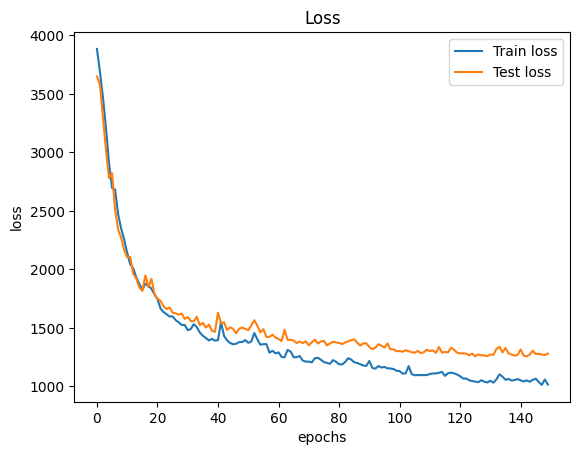

In [73]:
plt.figure()
plt.plot(losses, label="Loss")
plt.title("Loss")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend(["Train loss", "Test loss"])
plt.show()

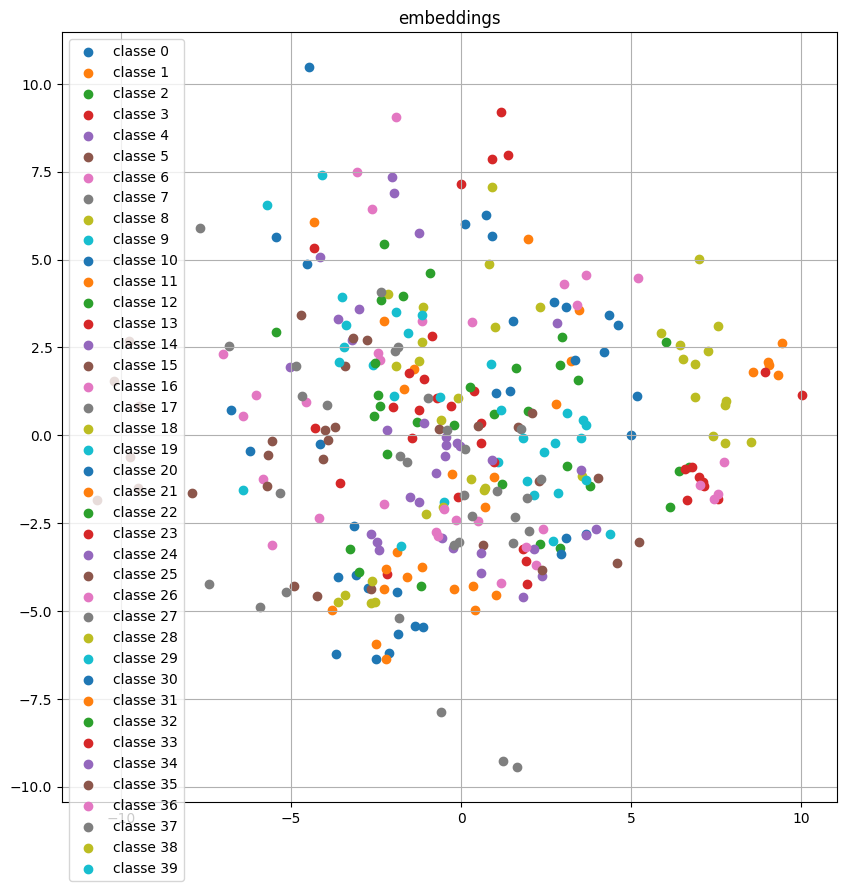

In [74]:
autoencoder.eval()
embeddings = []
avg_embeddings = []
with torch.no_grad():
    for images, labels in train_loader:
        #print(labels)
        #images = torch.flatten(images, 1)

        images = images.to(device)
        labels = labels.to(device)

        emb, output,_,_ = autoencoder(images)

        for i in range(emb.size(0)):
            embeddings.append([emb[i].cpu().tolist(), labels[i].cpu().item()])

    emb_np = np.array([item[0] for item in embeddings])
    lab_np = np.array([item[1] for item in embeddings])



    for cls in range(nb_classes):
        idx = np.where(lab_np == cls)[0]
        avg_emb = emb_np[idx].mean(axis=0)

        avg_embeddings.append(avg_emb)

        #print(f"classe {cls}: avg embedding = {avg_emb.tolist()}")

def plot_embeddings():
    embeddings_np = np.array([e[0] for e in embeddings])
    labels_np = np.array([e[1] for e in embeddings])

    pca = PCA(n_components=2) #reduction en 2D
    reduced_embeddings = pca.fit_transform(embeddings_np)

    plt.figure(figsize=(10, 10))
    for label in np.unique(labels_np):
        idx = labels_np == label
        plt.scatter(reduced_embeddings[idx, 0], reduced_embeddings[idx, 1], label=f"classe {label}")

    plt.title("embeddings")
    plt.legend()
    plt.grid(True)
    plt.show()



plot_embeddings()

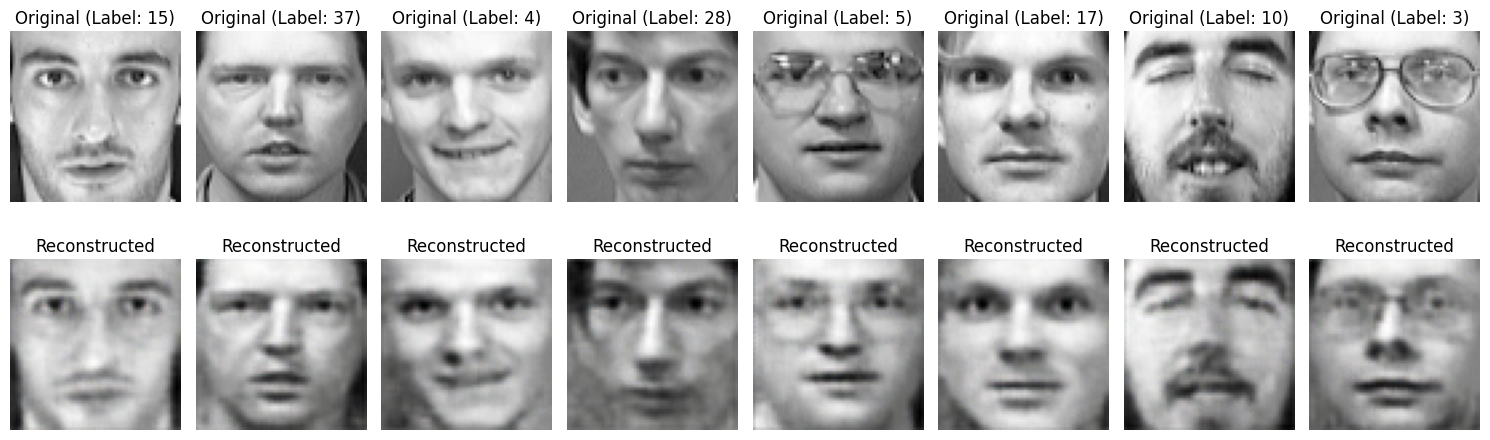

In [75]:
autoencoder.eval()

images, labels = next(iter(train_loader))
images = images.to(device)

with torch.no_grad():

    _,reconstructed_images, _,_ = autoencoder(images)


n = min(8, images.size(0))
fig, axs = plt.subplots(2, n, figsize=(15, 5))

for i in range(n):
    img = images[i].permute(1, 2, 0).cpu().numpy()
    mi, ma = img.min(), img.max()
    img_disp = (img - mi) / (ma - mi) if ma - mi > 1e-6 else img
    axs[0, i].imshow(img_disp)
    axs[0, i].set_title(f"Original (Label: {labels[i].item()})")
    axs[0, i].axis("off")

    recon_img = reconstructed_images[i].permute(1, 2, 0).cpu().numpy()
    mi, ma = recon_img.min(), recon_img.max()
    recon_disp = (recon_img - mi) / (ma - mi) if ma - mi > 1e-6 else recon_img
    axs[1, i].imshow(recon_disp)
    axs[1, i].set_title("Reconstructed")
    axs[1, i].axis("off")

plt.tight_layout()
plt.show()

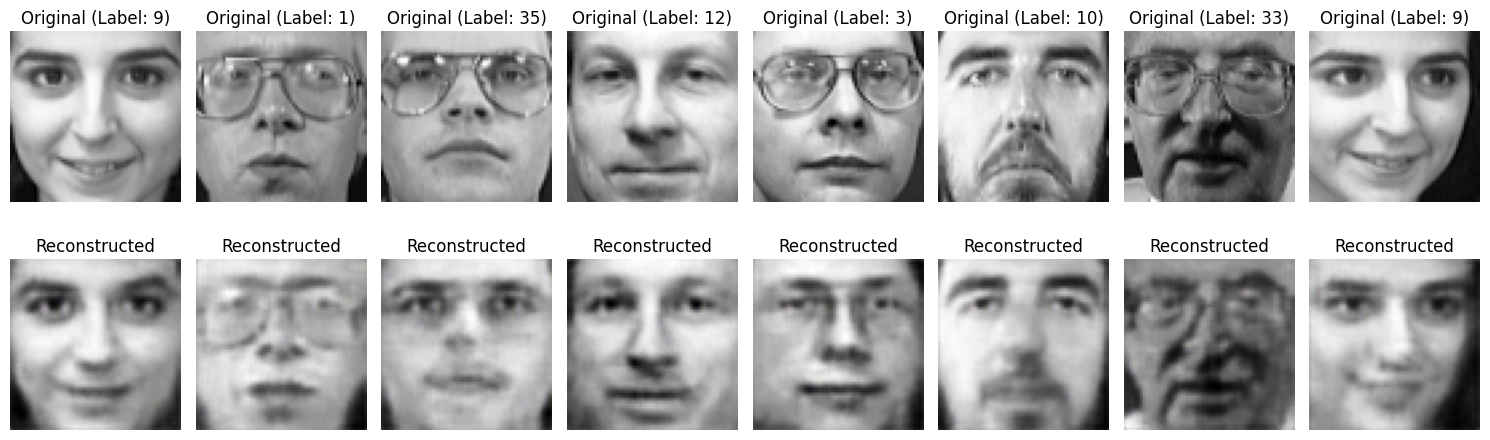

In [79]:
autoencoder.eval()

images, labels = next(iter(test_loader))
images = images.to(device)

with torch.no_grad():
    _,reconstructed_images,_,_ = autoencoder(images)


n = min(8, images.size(0))
fig, axs = plt.subplots(2, n, figsize=(15, 5))

for i in range(n):
    img = images[i].permute(1, 2, 0).cpu().numpy()
    mi, ma = img.min(), img.max()
    img_disp = (img - mi) / (ma - mi) if ma - mi > 1e-6 else img
    axs[0, i].imshow(img_disp)
    axs[0, i].set_title(f"Original (Label: {labels[i].item()})")
    axs[0, i].axis("off")

    recon_img = reconstructed_images[i].permute(1, 2, 0).cpu().numpy()
    mi, ma = recon_img.min(), recon_img.max()
    recon_disp = (recon_img - mi) / (ma - mi) if ma - mi > 1e-6 else recon_img
    axs[1, i].imshow(recon_disp)
    axs[1, i].set_title("Reconstructed")
    axs[1, i].axis("off")

plt.tight_layout()
plt.show()